Mean Response Time: 1.82 seconds
Standard Deviation: 1.92 seconds
Fitted Drift: 0.400
Fitted Noise: 1.200
Fitted Boundary: 2.500
Fitted Non-Decision Time: 0.300
Optimized Simulated Mean RT: 1.59 seconds
Optimized Simulated Standard Deviation: 0.41 seconds
KS Statistic: 0.370, P-value: 0.000


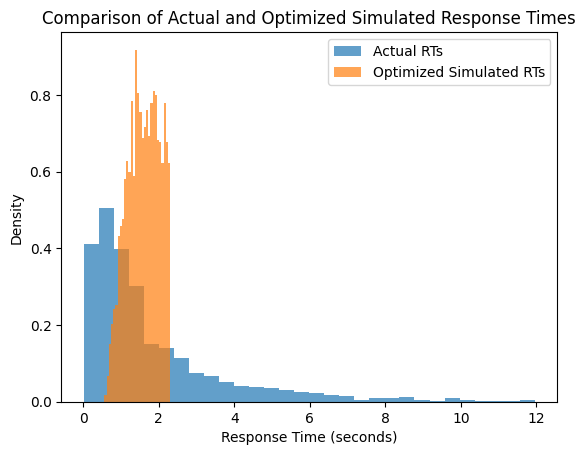

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import ks_2samp

# Step 1: Load the data
df = pd.read_csv("online_shoppers_intention.csv")

# Step 2: Filter data
df = df[df["Revenue"] == True]
df["RT"] = (df["Informational_Duration"] + df["ProductRelated_Duration"] + 1.0) / 1000.0#Converting to seconds
df = df[df["RT"] > 0]  # Remove invalid RTs

# Step 3: Outlier Removal
lower_bound = df["RT"].quantile(0.01)
upper_bound = df["RT"].quantile(0.99)
df = df[(df["RT"] >= lower_bound) & (df["RT"] <= upper_bound)]

# Step 4: Actual Mean And SD
mean_rt = df["RT"].mean()
std_rt = df["RT"].std()
print(f"Mean Response Time: {mean_rt:.2f} seconds")
print(f"Standard Deviation: {std_rt:.2f} seconds")

# Step 5: DDM simulation
def simulate_ddm(trials, drift, noise, boundary, t_nd, time_step=0.001, max_time=2):
    reaction_times = []
    for _ in range(trials):
        x = 0  # Starting point
        t = 0
        while abs(x) < boundary and t < max_time:
            x += drift * time_step + noise * np.sqrt(time_step) * np.random.normal()
            t += time_step
        if abs(x) >= boundary and t < max_time:
            reaction_times.append(t + t_nd)  # Add non-decision time
    return np.array(reaction_times)

# Step 6: loss function Declaration
def loss_function(params, actual_rts):
    drift, noise, boundary, t_nd = params
    simulated_rts = simulate_ddm(
        trials=1000, drift=drift, noise=noise, boundary=boundary, t_nd=t_nd
    )
    sim_mean = simulated_rts.mean()
    sim_std = simulated_rts.std()
    # Loss is the squared error between mean and standard deviation
    mean_error = (sim_mean - actual_rts.mean()) ** 2
    std_error = (sim_std - actual_rts.std()) ** 2
    return mean_error + std_error

# Step 7: Intial Guesses and Parameter bound assumptions
initial_params = [0.4, 1.2, 2.5, 0.3]  # Initial guesses: drift, noise, boundary, t_nd
bounds = [(-1, 1), (0.1, 2), (0.5, 3), (0, 1)]  # Parameter bounds
result = minimize(loss_function, initial_params, args=(df["RT"]), bounds=bounds)

#optimized parameters
fitted_drift, fitted_noise, fitted_boundary, fitted_t_nd = result.x
print(f"Fitted Drift: {fitted_drift:.3f}")
print(f"Fitted Noise: {fitted_noise:.3f}")
print(f"Fitted Boundary: {fitted_boundary:.3f}")
print(f"Fitted Non-Decision Time: {fitted_t_nd:.3f}")

# Step 8: Simulate DDM with optimized parameters
optimized_rts = simulate_ddm(
    trials=10000,  # Increased trials for smoother distribution
    drift=fitted_drift,
    noise=fitted_noise,
    boundary=fitted_boundary,
    t_nd=fitted_t_nd
)

# Step 9: Compute mean and standard deviation of optimized RTs
sim_mean_rt = optimized_rts.mean()
sim_std_rt = optimized_rts.std()
print(f"Optimized Simulated Mean RT: {sim_mean_rt:.2f} seconds")
print(f"Optimized Simulated Standard Deviation: {sim_std_rt:.2f} seconds")

# Step 10: Validate the fit using KS test
ks_stat, p_value = ks_2samp(df["RT"], optimized_rts)
print(f"KS Statistic: {ks_stat:.3f}, P-value: {p_value:.3f}")

# Step 11: Visualization
plt.hist(df["RT"], bins=30, alpha=0.7, label="Actual RTs", density=True)
plt.hist(optimized_rts, bins=30, alpha=0.7, label="Optimized Simulated RTs", density=True)
plt.title("Comparison of Actual and Optimized Simulated Response Times")
plt.xlabel("Response Time (seconds)")
plt.ylabel("Density")
plt.legend()
plt.show()



Fitting DDM for Familiar Products group...
Fitted Drift: 0.400
Fitted Noise: 1.200
Fitted Boundary: 2.500
Fitted Non-Decision Time: 0.300
Actual Mean RT: 0.57 seconds, Actual Std RT: 0.32 seconds
Simulated Mean RT: 1.60 seconds, Simulated Std RT: 0.42 seconds
KS Statistic: 0.830, P-value: 0.000

Fitting DDM for Unfamiliar Products group...
Fitted Drift: 0.400
Fitted Noise: 1.200
Fitted Boundary: 2.500
Fitted Non-Decision Time: 0.300
Actual Mean RT: 3.30 seconds, Actual Std RT: 2.72 seconds
Simulated Mean RT: 1.60 seconds, Simulated Std RT: 0.42 seconds
KS Statistic: 0.510, P-value: 0.000


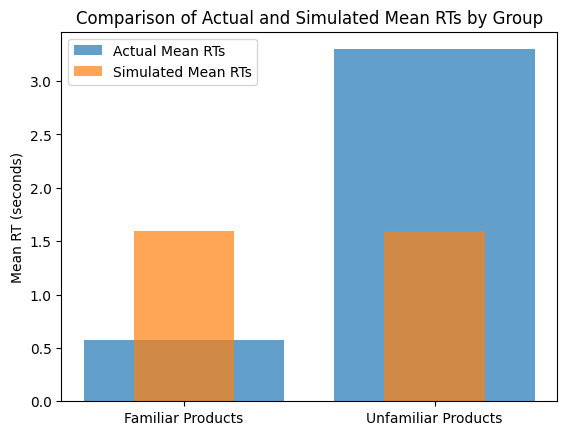

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import ks_2samp

# Step 1: Load the data
df = pd.read_csv("online_shoppers_intention.csv")

# Step 2: Filter data
df = df[df["Revenue"] == True]
df["RT"] = (df["Informational_Duration"] + df["ProductRelated_Duration"] + 1.0) / 1000.0  # Convert to seconds
df = df[df["RT"] > 0]  # Remove invalid RTs

# Step 3: Median
median_duration = df["ProductRelated_Duration"].median()

# Group 1: Familiar products
familiar_products = df[df["ProductRelated_Duration"] <= median_duration]

# Group 2: Unfamiliar products
unfamiliar_products = df[df["ProductRelated_Duration"] > median_duration]

# Step 4: Define DDM simulation function with non-decision time
def simulate_ddm(trials, drift, noise, boundary, t_nd, time_step=0.001, max_time=2):
    reaction_times = []
    for _ in range(trials):
        x = 0  # Starting point
        t = 0
        while abs(x) < boundary and t < max_time:
            x += drift * time_step + noise * np.sqrt(time_step) * np.random.normal()
            t += time_step
        if abs(x) >= boundary and t < max_time:
            reaction_times.append(t + t_nd)  # Add non-decision time
    return np.array(reaction_times)

# Step 5: Define loss function
def loss_function(params, actual_rts):
    drift, noise, boundary, t_nd = params
    simulated_rts = simulate_ddm(
        trials=1000, drift=drift, noise=noise, boundary=boundary, t_nd=t_nd
    )
    sim_mean = simulated_rts.mean()
    sim_std = simulated_rts.std()
    # Compute loss as the squared error between mean and standard deviation
    mean_error = (sim_mean - actual_rts.mean()) ** 2
    std_error = (sim_std - actual_rts.std()) ** 2
    return mean_error + std_error

# Step 6: Fit DDM
def fit_ddm(group_name, group_data):
    print(f"\nFitting DDM for {group_name} group...")

    # Optimize parameters for the group
    initial_params = [0.4, 1.2, 2.5, 0.3]  # Initial guesses
    bounds = [(-1, 1), (0.1, 2), (0.5, 3), (0, 1)]  # Parameter bounds
    result = minimize(loss_function, initial_params, args=(group_data["RT"]), bounds=bounds)

    # Extract optimized parameters
    fitted_drift, fitted_noise, fitted_boundary, fitted_t_nd = result.x
    print(f"Fitted Drift: {fitted_drift:.3f}")
    print(f"Fitted Noise: {fitted_noise:.3f}")
    print(f"Fitted Boundary: {fitted_boundary:.3f}")
    print(f"Fitted Non-Decision Time: {fitted_t_nd:.3f}")

    # Simulate RTs for the group
    simulated_rts = simulate_ddm(
        trials=10000, drift=fitted_drift, noise=fitted_noise, boundary=fitted_boundary, t_nd=fitted_t_nd
    )

    # Evaluate the fit
    actual_mean = group_data["RT"].mean()
    actual_std = group_data["RT"].std()
    sim_mean = simulated_rts.mean()
    sim_std = simulated_rts.std()
    ks_stat, p_value = ks_2samp(group_data["RT"], simulated_rts)

    print(f"Actual Mean RT: {actual_mean:.2f} seconds, Actual Std RT: {actual_std:.2f} seconds")
    print(f"Simulated Mean RT: {sim_mean:.2f} seconds, Simulated Std RT: {sim_std:.2f} seconds")
    print(f"KS Statistic: {ks_stat:.3f}, P-value: {p_value:.3f}")

    return {
        "Group": group_name,
        "Fitted Drift": fitted_drift,
        "Fitted Noise": fitted_noise,
        "Fitted Boundary": fitted_boundary,
        "Fitted Non-Decision Time": fitted_t_nd,
        "Actual Mean RT": actual_mean,
        "Actual Std RT": actual_std,
        "Simulated Mean RT": sim_mean,
        "Simulated Std RT": sim_std,
        "KS Statistic": ks_stat,
        "P-Value": p_value
    }

# Step 7: Fit models for familiar and unfamiliar products
familiar_results = fit_ddm("Familiar Products", familiar_products)
unfamiliar_results = fit_ddm("Unfamiliar Products", unfamiliar_products)

# Step 8: Visualization
groups = ["Familiar Products", "Unfamiliar Products"]
mean_rts = [familiar_results["Actual Mean RT"], unfamiliar_results["Actual Mean RT"]]
sim_mean_rts = [familiar_results["Simulated Mean RT"], unfamiliar_results["Simulated Mean RT"]]

plt.bar(groups, mean_rts, alpha=0.7, label="Actual Mean RTs")
plt.bar(groups, sim_mean_rts, alpha=0.7, label="Simulated Mean RTs", width=0.4)
plt.title("Comparison of Actual and Simulated Mean RTs by Group")
plt.ylabel("Mean RT (seconds)")
plt.legend()
plt.show()